<a href="https://colab.research.google.com/github/Tingche-Lyu/Optimization-at-NYU/blob/main/Optimization_Computational_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear programming course: numerical examples

In [ ]:
import numpy as np
import scipy.sparse as spr
import pandas as pd
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from scipy import optimize
from math import sqrt


In [ ]:
!pip install gurobipy
import gurobipy as grb

# Lecture 1: the diet problem

### Downloading Stigler's data

Our dataset was directly taken from Stigler's article. It is a .csv file called `StiglerData1939.txt'. Have a look at the diet problem data:

In [ ]:
import scipy.sparse as sp
import pandas as pd
import numpy as np
from tabulate import tabulate

thedata = pd.read_csv('https://raw.githubusercontent.com/math-econ-code/mec_optim_2021-01/master/data_mec_optim/lp_stigler-diet/StiglerData1939.txt', sep='\t')
thedata = thedata.dropna(how = 'all')
thedata.head()

,Commodity,Unit,Price Aug.15 1939(cents),Edible Weight per $1.00 (grams),Calories (1000),Protein(grams),Calcium(grams),Iron(mg.),Vitamin A(1000 I.U),Thiamine(mg.),Riboflavin(mg.),Niacin(mg.),Asorbic Acid (mg.)
0,1. Wheat Flour (Enriched),10 lb.,36.0,12600.0,44.7,1411.0,2.0,365.0,NaN,55.4,33.3,441.0,NaN
1,2. Macaroni,1 lb.,14.1,3217.0,11.6,418.0,0.7,54.0,NaN,3.2,1.9,68.0,NaN
2,3. Wheat Cereal (Enriched),28 oz.,24.2,3280.0,11.8,377.0,14.4,175.0,NaN,14.4,8.8,114.0,NaN
3,4. Corn Flakes,8 oz.,7.1,3194.0,11.4,252.0,0.1,56.0,NaN,13.5,2.3,68.0,NaN
4,5. Corn Meal,1 lb.,4.6,9861.0,36.0,897.0,1.7,99.0,30.9,17.4,7.9,106.0,NaN


Our dataset has the nutritional content of $77$ commodities. The final row contains the daily minimum requirement of each of these nutrients:

In [ ]:
commodities = (thedata['Commodity'].values)[:-1]
allowance = thedata.iloc[-1, 4:].fillna(0).transpose()
allowance

Calories (1000)         3.0
Protein(grams)         70.0
Calcium(grams)          0.8
Iron(mg.)              12.0
Vitamin A(1000 I.U)     5.0
Thiamine(mg.)           1.8
Riboflavin(mg.)         2.7
Niacin(mg.)            18.0
Asorbic Acid (mg.)     75.0
Name: 77, dtype: float64

To solve the primal problem we need to construct the objects $N$ and $d$. $c$ is simply a vector of ones, the size of the number of commodities. $N$ is a matrix of amount of nutrients in each commodity. $d$ is the required daily allowance of each nutrient.

In [ ]:
N_i_j = thedata.iloc[:-1, 4:].fillna(0).transpose().values
nbi, nbj = N_i_j.shape
c_j = np.ones(nbj)
d_i = np.array(allowance)

Using Gurobi, numerically solve the diet problem:

In [ ]:
dietmodel = grb.Model()
varq_j = dietmodel.addMVar(nbj)
dietmodel.setObjective(varq_j.sum(), grb.GRB.MINIMIZE)
c = dietmodel.addConstr(N_i_j @ varq_j >= d_i)
dietmodel.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 9 rows, 77 columns and 570 nonzeros
Model fingerprint: 0x7ae6b743
Coefficient statistics:
  Matrix range     [1e-01, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 8e+01]
Presolve removed 0 rows and 47 columns
Presolve time: 0.03s
Presolved: 9 rows, 30 columns, 240 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.384688e+01   0.000000e+00      0s
       5    1.0866228e-01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.04 seconds (0.00 work units)
Optimal objective  1.086622782e-01


Get the optimal solutions `x`, the dual solution `pi` and the value function `objval` by:

In [ ]:
q_j , π_i, val = dietmodel.getAttr('X') , dietmodel.getAttr('pi'), dietmodel.getAttr('objVal')

Print the optimal diet by:

In [ ]:
def print_optimal_diet(q_j):
    print('***Optimal solution***')
    total,thelist = 0.0, []
    for j,commodity in enumerate(commodities):
        if q_j[j] > 0:
            total += q_j[j] * 365
            thelist.append([commodity,q_j[j]])
    thelist.append(['Total cost (optimal):', total])
    print(tabulate(thelist))

print_optimal_diet(q_j)

***Optimal solution***
-------------------------  -----------
1. Wheat Flour (Enriched)   0.0295191
30. Liver (Beef)            0.00189256
46. Cabbage                 0.0112144
52. Spinach                 0.00500766
69. Navy Beans Dried        0.0610286
Total cost (optimal):      39.6617
-------------------------  -----------


# Lecture 4: computation of a LP

Compute the lp in lecture 4 using:

In [ ]:
d_i = np.array([5,3,-1])
c_j = np.array([2,3,-1])
A_i_j = np.array([[1,1,-1],[2,-3,1],[-1,2,-1]])
model = grb.Model()
x_j = model.addMVar(3)
model.setObjective(c_j @ x_j, grb.GRB.MINIMIZE)
model.addConstr(A_i_j @ x_j <= d_i)
model.optimize()
model.getAttr('x')

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 3 rows, 3 columns and 9 nonzeros
Model fingerprint: 0x9a8abd8d
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve time: 0.03s
Presolved: 3 rows, 3 columns, 9 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.0000000e+30   2.500000e+29   1.000000e+00      0s
       2   -3.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.04 seconds (0.00 work units)
Optimal objective -3.000000000e+00


[0.0, 0.0, 3.0]

# Lecture 5: geometry of the simplex

Geometric plot of the feasible set in 2D:

In [ ]:
!pip install polytope

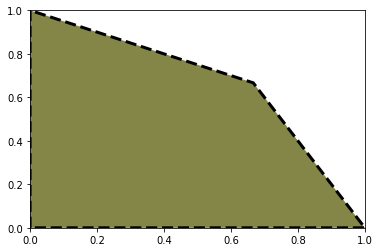

In [ ]:
import polytope as pc
p1 = pc.Polytope(np.array([[-1.,0],[0,-1.], [1.,2.],[2., 1.]]), np.array([0,0,2.,2.]))
p1.plot()

# Lectures 8 and 9: matrix games

In [ ]:
Pi_i_j = np.array([[50, 100, 93.8], 
                    [93.9, 60.0, 82.8], 
                    [97.6, 100, 73.2]])
Pi_i_j

array([[ 50. , 100. ,  93.8],
       [ 93.9,  60. ,  82.8],
       [ 97.6, 100. ,  73.2]])

Compute using:

In [ ]:
matrixgame_model = grb.Model()
nbi,nbj = Pi_i_j.shape
p_iv = matrixgame_model.addMVar(shape = nbi)
sv = matrixgame_model.addMVar(1, lb = - grb.GRB.INFINITY )
matrixgame_model.setObjective(sv, grb.GRB.MAXIMIZE)
matrixgame_model.addConstr( np.ones( (nbj,1) ) @ sv - Pi_i_j.T @ p_iv   <=0  )
matrixgame_model.addConstr( p_iv.sum()==1 )
matrixgame_model.optimize() 



Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 4 rows, 4 columns and 15 nonzeros
Model fingerprint: 0xc617c31e
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.02s
Presolved: 3 rows, 4 columns, 11 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.7600000e+01   3.050000e+00   0.000000e+00      0s
       2    8.2949748e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.04 seconds (0.00 work units)
Optimal objective  8.294974813e+01


In [ ]:
p_i = np.array(matrixgame_model.getAttr('x'))[:-1]
p_i

array([0.27465, 0.42626, 0.2991 ])

In [ ]:
q_j = np.array(matrixgame_model.getAttr('pi'))[:-1]
q_j

array([0.26506, 0.12247, 0.61247])

In [ ]:
np.array(matrixgame_model.getAttr('x'))[-1]

82.94974812946724

In [ ]:
np.array(matrixgame_model.getAttr('pi'))[-1]

82.94974812946725

In [ ]:
matrixgame_model = grb.Model()
matrixgame_model.Params.OutputFlag = 0 # for silent execution
nbi,nbj = Pi_i_j.shape
p_iv = matrixgame_model.addMVar(shape = nbi)
sv = matrixgame_model.addMVar(1, lb = - grb.GRB.INFINITY )
matrixgame_model.setObjective(sv, grb.GRB.MAXIMIZE)
matrixgame_model.addConstr( np.ones( (nbj,1) ) @ sv - Pi_i_j.T @ p_iv   <=0  )
matrixgame_model.addConstr( p_iv.sum()==1 )

matrixgame_model.optimize() 
p_i = np.array(matrixgame_model.getAttr('x'))[:-1]
S = np.array(matrixgame_model.getAttr('x'))[-1:]
q_j = np.array(matrixgame_model.getAttr('pi'))[:-1]
print(p_i,q_j,S)

[0.27465 0.42626 0.2991 ] [0.26506 0.12247 0.61247] [82.94975]


In [ ]:
Pi_i_j = np.array([[50, 100, 93.8], [93.9, 60.0, 82.8], [97.6, 100, 73.2]])

matrixgame_model_bis=grb.Model()
matrixgame_model_bis.Params.OutputFlag = 0 # for silent execution
nbi,nbj = Pi_i_j.shape
x = matrixgame_model_bis.addMVar(shape=nbi)
matrixgame_model_bis.setObjective( x.sum(), grb.GRB.MINIMIZE)
matrixgame_model_bis.addConstr(Pi_i_j.T @ x >= np.ones(nbj))
matrixgame_model_bis.optimize() 
xstar = np.array(matrixgame_model_bis.getAttr('x'))
ystar = np.array(matrixgame_model_bis.getAttr('pi'))
S = 1 /  xstar.sum()
p_i = S * xstar
q_j = S * ystar
print(p_i,q_j,S)


[0.27465 0.42626 0.2991 ] [0.26506 0.12247 0.61247] 82.94974812946724


# Lecture 10

Network flow problems.

In [ ]:
    M_z_a = np.array(
    [[-1,0,0,0,0,0,0,0,0,0],
    [0,-1,-1,0,0,0,0,0,0,0],
    [0,0,0,-1,-1,0,0,0,0,0],
    [1,1,0,1,0,-1,-1,0,0,0],
    [0,0,1,0,1,0,0,-1,-1,-1],
    [0,0,0,0,0,1,0,1,0,0],
    [0,0,0,0,0,0,1,0,1,0],
    [0,0,0,0,0,0,0,0,0,1]])
    

In [ ]:
q_z = np.array([-35,	-20,	-15,	0	, 0,	30,	15,	25])

In [ ]:
c_a = np.array([2,	7,	11,	6,	8,	9,	7,	8,	12,	3])

In [ ]:
mincostflow =grb.Model()
nbz,nba = M_z_a.shape
mu_a = mincostflow.addMVar(shape=nba)
mincostflow.setObjective( mu_a @ c_a, grb.GRB.MINIMIZE)
mincostflow.addConstr(M_z_a @ mu_a == q_z)
mincostflow.optimize() 

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 8 rows, 10 columns and 20 nonzeros
Model fingerprint: 0x90167b7f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 4e+01]
Presolve removed 6 rows and 6 columns
Presolve time: 0.02s
Presolved: 2 rows, 4 columns, 8 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.8993300e+02   4.005600e+01   0.000000e+00      0s
       1    8.2000000e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.03 seconds (0.00 work units)
Optimal objective  8.200000000e+02


In [ ]:
musol_a = np.array(mincostflow.getAttr('x'))
musol_a

array([35., 10., 10.,  0., 15., 30., 15.,  0.,  0., 25.])

In [ ]:
psol_z = np.array(mincostflow.getAttr('pi'))
psol_z

array([ -6., -11.,  -8.,  -4.,   0.,   5.,   3.,   3.])

# Lecture 11: Shortest paths; matching models

Load subway data:

In [ ]:
thepath = 'https://raw.githubusercontent.com/math-econ-code/mec_optim_2021-01/master/data_mec_optim/'
arcs_data = pd.read_csv(thepath+'networks_subway/NYC/arcs.csv', sep=',')#.sort_values(by=['route_id'])
nodes_data = pd.read_csv(thepath+ 'networks_subway/NYC/nodes.csv', sep=',')
nodes_names = [i+' '+j for i,j in zip(nodes_data.stop_name,nodes_data.route_id)]
arcs = [(o-1,d-1) for (o,d) in list(zip(arcs_data.from_stop_nb,arcs_data.to_stop_nb))]
nbNodes,nbArcs = len(nodes_names),len(arcs)

In [ ]:
nbNodes,nbArcs

(501, 1290)

Input it:

In [ ]:
c_a = np.array(arcs_data.dis_line)
M_z_a = spr.csr_matrix((np.concatenate([-np.ones(nbArcs),np.ones(nbArcs)]), 
                        ( [o for o,d in arcs]+[d for o,d in arcs],list(range(nbArcs))+list(range(nbArcs)))), 
                       shape = (nbNodes,nbArcs))

In [ ]:
origin_node,destination_node = (452, 14)
print('origin = '+nodes_names[origin_node] + ' ; destination = ' + nodes_names[destination_node])
q_z = np.zeros(nbNodes)
q_z[origin_node] = -1
q_z[destination_node] = 1

origin = 8 St - NYU (N/R) ; destination = 116 St - Columbia University (1)


In [ ]:
m=grb.Model()
mu_a = m.addMVar(shape=nbArcs)
m.setObjective(c_a @ mu_a, grb.GRB.MINIMIZE)
m.addConstr( M_z_a @ mu_a == q_z)
m.optimize()
if m.status == grb.GRB.Status.OPTIMAL:
    mustar_a = m.getAttr('x')
    pstar_z = m.getAttr('pi')


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 501 rows, 1290 columns and 2580 nonzeros
Model fingerprint: 0x90d46ae6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 357 rows and 714 columns
Presolve time: 0.02s
Presolved: 144 rows, 576 columns, 1152 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.000000e+00   0.000000e+00      0s
      43    2.3979662e+04   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.05 seconds (0.00 work units)
Optimal objective  2.397966180e+04


In [ ]:
def pathfinder(mu,sind,tind):
    t = tind
    arcs_active = [(x,y) for (a,(x,y)) in zip(range(nbArcs),arcs) if (mu[a] > 0) ]
    current = sind
    path = [nodes_names[current]]
    while current != t:
        (x,y) = next((x,y) for (x,y) in arcs_active if x==current)
        path.append(nodes_names[y])
        current = y
        arcs_active.remove((x,y))
    return path

pathfinder(mustar_a,origin_node,destination_node)  

['8 St - NYU (N/R)',
 '14 St - Union Sq (N/R/Q)',
 '34 St - Herald Sq (Q/N)',
 'Times Sq - 42 St (R/Q)',
 'Times Sq - 42 St (1/3)',
 '72 St (1/2)',
 '96 St (2/1/3)',
 '103 St (1)',
 'Cathedral Pkwy (1)',
 '116 St - Columbia University (1)']

## Shortest path via dynamic programming

In [ ]:
def shortestPathDP(origin_node,destination_node):
    successor = {z: None for z in range(nbNodes)}
    C_z = np.inf * np.ones(nbNodes)
    C_z[destination_node] = 0
    delta_x_y = np.zeros((nbNodes,nbNodes))
    update = True
    while update:
        update = False
        for a,(x,y) in zip(range(nbArcs),arcs):
            if c_a[a]  +  C_z[y]  < C_z[x]:
                update = True
                C_z[x] = c_a[a ] +  C_z[y]
                successor[x]=y

    z = origin_node
    path = [nodes_names[z]]
    while (successor[z] != destination_node):
        z = successor[z] 
        path.append(nodes_names[z])
    path.append(nodes_names[destination_node])
    print("Cost = ",C_z[origin_node])
    return path

shortestPathDP(origin_node,destination_node)

Cost =  23979.661803262097


['8 St - NYU (N/R)',
 '14 St - Union Sq (N/R/Q)',
 '34 St - Herald Sq (Q/N)',
 'Times Sq - 42 St (R/Q)',
 'Times Sq - 42 St (1/3)',
 '72 St (1/2)',
 '96 St (2/1/3)',
 '103 St (1)',
 'Cathedral Pkwy (1)',
 '116 St - Columbia University (1)']

# Lecture 14: Review for midterm (practice midterm)

In [ ]:
Pi_i_j = np.array([[-1,1], 
                    [2,-2]])
Pi_i_j

array([[-1,  1],
       [ 2, -2]])

In [ ]:
matrixgame_model = grb.Model()
nbi,nbj = Pi_i_j.shape
p_iv = matrixgame_model.addMVar(shape = nbi)
sv = matrixgame_model.addMVar(1, lb = - grb.GRB.INFINITY )
matrixgame_model.setObjective(sv, grb.GRB.MAXIMIZE)
matrixgame_model.addConstr( np.ones( (nbj,1) ) @ sv - Pi_i_j.T @ p_iv   <=0  )
matrixgame_model.addConstr( p_iv.sum()==1 )
matrixgame_model.optimize() 

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 3 rows, 3 columns and 8 nonzeros
Model fingerprint: 0x76637c3f
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2 rows and 1 columns
Presolve time: 0.03s
Presolved: 1 rows, 2 columns, 2 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s
       0   -0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.04 seconds (0.00 work units)
Optimal objective -0.000000000e+00


In [ ]:
y_i = np.array(matrixgame_model.getAttr('x'))[:-1]
y_i

array([0.66667, 0.33333])

In [ ]:
x_j = np.array(matrixgame_model.getAttr('pi'))[:-1]
x_j

array([0.5, 0.5])

# Midterm numerical questions

## Question 3

In [ ]:
y_i = np.array([1,2,3,4,5])
#c_j = np.array([2,3,-1])

model = grb.Model()
t = model.addMVar(1,lb = - grb.GRB.INFINITY)
a_i = model.addMVar(5)

model.setObjective(a_i.sum(), grb.GRB.MINIMIZE)
model.addConstr(np.eye(5) @ a_i + np.ones((5,1)) @ t >= y_i)
model.addConstr(np.eye(5) @ a_i - np.ones((5,1)) @ t >= - y_i)

model.optimize()
print('value of the problem =', model.getAttr('objVal'))
print('value of t =', t.X.item() )

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 10 rows, 6 columns and 20 nonzeros
Model fingerprint: 0x11410b79
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 1 rows and 0 columns
Presolve time: 0.02s
Presolved: 9 rows, 6 columns, 26 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.000000e+01   0.000000e+00      0s
       5    6.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.05 seconds (0.00 work units)
Optimal objective  6.000000000e+00
value of the problem = 6.0
value of t = 3.0


## Question 5

In [ ]:
Pi_i_j = np.array([[2,0,2,0],
[1,0,0,1],
[0,3,3,0],
[0,4,0,4]])

matrixgame_model = grb.Model()
matrixgame_model.Params.OutputFlag = 0 # for silent execution
nbi,nbj = Pi_i_j.shape
p_iv = matrixgame_model.addMVar(shape = nbi)
sv = matrixgame_model.addMVar(1, lb = - grb.GRB.INFINITY )
matrixgame_model.setObjective(sv, grb.GRB.MINIMIZE)
matrixgame_model.addConstr( np.ones( (nbj,1) ) @ sv - Pi_i_j.T @ p_iv   >=0  )
matrixgame_model.addConstr( p_iv.sum()==1 )

matrixgame_model.optimize() 
p_i = np.array(matrixgame_model.getAttr('x'))[:-1]
S = np.array(matrixgame_model.getAttr('x'))[-1:]
q_j = np.array(matrixgame_model.getAttr('pi'))[:-1]
print(p_i,q_j,S)


[0.   0.75 0.25 0.  ] [0.75 0.25 0.   0.  ] [0.75]


## Question 6

In [ ]:
nbi = 5
nbj = 4
C_i_j = np.array([[10,45,15,10],
[5,25,30,25],
[35,15,20,15],
[75,40,35,30],
[20,60,5,65]]
)
nba = nbi*nbj
nbz = nbi+nbj
M_z_a = np.zeros((nbz,nba))
c_a = np.zeros(nba)
p_i = np.array([3,4,6,2,5])
q_j = np.array([3,7,6,4])
q_z = np.zeros(nbz)
a = 0
for i in range(nbi):
  for j in range(nbj):
    M_z_a[i,a] = -1
    M_z_a[j+nbi,a] = 1
    c_a[a] = C_i_j[i,j]
    q_z[i] = - p_i[i]
    q_z[nbi+j] = q_j[j]
    a = a+1
M_z_a

array([[-1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1., -1., -1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
        -1., -1., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., -1., -1., -1., -1.],
       [ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  

In [ ]:
m=grb.Model()
mu_a = m.addMVar(shape=nba)
m.setObjective(c_a @ mu_a, grb.GRB.MINIMIZE)
m.addConstr( M_z_a @ mu_a == q_z)
m.optimize()
if m.status == grb.GRB.Status.OPTIMAL:
    mustar_a = m.getAttr('x')
    pstar_z = m.getAttr('pi')


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 9 rows, 20 columns and 40 nonzeros
Model fingerprint: 0xfcaa41d6
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 7e+00]
Presolve time: 0.03s
Presolved: 9 rows, 20 columns, 40 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.9000000e+02   6.000000e+00   0.000000e+00      0s
       4    2.5000000e+02   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.04 seconds (0.00 work units)
Optimal objective  2.500000000e+02


In [ ]:
m.getAttr('objVal')

250.0

In [ ]:
nbi = 5
nbj = 4
C_i_j = np.array([[10,45,15,10],
[50000,25,30,25],
[35,15,20,15],
[75,40,35,30],
[20,60,5,65]]
)
nba = nbi*nbj
nbz = nbi+nbj
M_z_a = np.zeros((nbz,nba))
c_a = np.zeros(nba)
p_i = np.array([3,4,6,2,5])
q_j = np.array([3,7,6,4])
q_z = np.zeros(nbz)
a = 0
for i in range(nbi):
  for j in range(nbj):
    M_z_a[i,a] = -1
    M_z_a[j+nbi,a] = 1
    c_a[a] = C_i_j[i,j]
    q_z[i] = - p_i[i]
    q_z[nbi+j] = q_j[j]
    a = a+1

m=grb.Model()
mu_a = m.addMVar(shape=nba)
m.setObjective(c_a @ mu_a, grb.GRB.MINIMIZE)
m.addConstr( M_z_a @ mu_a == q_z)
m.optimize()
if m.status == grb.GRB.Status.OPTIMAL:
    mustar_a = m.getAttr('x')
    pstar_z = m.getAttr('pi')
m.getAttr('objVal')

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 9 rows, 20 columns and 40 nonzeros
Model fingerprint: 0x08477d8e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 7e+00]
Presolve time: 0.02s
Presolved: 9 rows, 20 columns, 40 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0500000e+02   1.200000e+01   0.000000e+00      0s
       5    3.1000000e+02   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.03 seconds (0.00 work units)
Optimal objective  3.100000000e+02


310.0

# Lecture 18: gradient descent

In [ ]:
np.random.seed(77)
d = 10
a = 3
A = 7
kappa = A / a
draws = np.random.uniform(size = d)
eigenvalues =  a+(A-a)* ((draws - draws.min()) / (draws.max() - draws.min()) )
U = ortho_group.rvs(d) # generates a random orthogonal matrix
Q = U.T @ np.diag(eigenvalues ) @ U

# np.linalg.eig(Q)[0] # check that it has indeed the right eigenvalues 

def E(y):
  return  y.T @ Q @ y / 2 

def g(y):
  return Q @ y

y0 = 100*np.random.normal(size = d)

In [ ]:
keep_going = True
abs_tol = 1e-10
maxIt = 100
yk = y0
k = 0
Elist = [E(yk)]
while keep_going:
  gk = g(yk)
  alphak = gk.dot(gk) / gk.dot(Q @ gk)
  yk = yk - alphak * gk
  k = k+1
  Ek = E(yk)
  Elist.append(Ek)
  if k>maxIt:
    print('Max iteration reached.')
    keep_going = False
  if Ek < abs_tol:
    keep_going = False
print(yk)
print(k)
Evalues= np.array(Elist)


[-0.  0. -0. -0. -0. -0.  0. -0.  0.  0.]
17


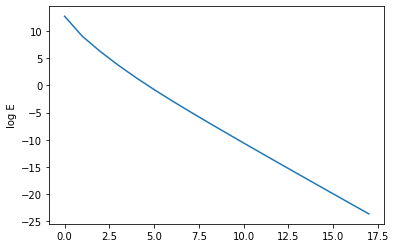

In [ ]:
plt.plot(np.log(np.array(Evalues)))
plt.ylabel('log E')
plt.show()

In [ ]:
actual_rate = (Evalues[k] / Evalues[0]) ** (1 / (k+1))
worse_rate =  ((A-a)*(A-a)) / ((a+A)*(a+A)) 


print('actual rate:', actual_rate)
print('worse rate   :', worse_rate)


actual rate: 0.1323156385856514
worse rate   : 0.16


# Lecture 19: Armijo's rule

In [ ]:
def armijo(f,xk,fk,gk,dk,alpha0, eta=2,epsilon = 0.2, maxIt = 10):
  cont = True
  alpha = alpha0
  it = 0
  direction = 0
  while cont:
    if f(xk+alpha*dk) <= fk + epsilon * gk * alpha: # if we are too low
      if direction ==-1: # if we are too low and if we were going down 
        alpha = alpha / epsilon # go back to previous value of alpha
        cont=False # and stop
      else: # if we are too low and if we were going up or just started
        direction = 1 # set direction upward
        alpha = alpha * eta # and increase alpha
    elif f(xk+eta*alpha*dk) > fk + epsilon * gk * eta*alpha: # if we are too high
      if direction == 1: # if we are too high and we were going up
        alpha = alpha / eta # go back to previous value of alpha
        cont=False # and stop
      else: # if we are too high and if we have just started
        direction = -1 # set direction downward
        alpha = alpha * epsilon # and decrease alpha
      if it>maxIt: # at some point, stop
        cont=False
  return alpha




# Lecture 20: an application to pricing
 

In [ ]:
U_x_y = np.array([[2,1,3],[1,3,2]])
n_x = np.array([10,8])
m_y = np.array([3,5,4])

def f(p_y):
    return (  (n_x* np.log(1+ np.exp( U_x_y - p_y[None,:] ).sum(axis = 1))).sum() + m_y.dot(p_y)  ) 

def g(p_y):
    denom_x = 1+ np.exp( U_x_y - p_y[None,:] ).sum(axis = 1)
    ES_y = m_y -  (np.exp( U_x_y - p_y[None,:] ) * (n_x/ denom_x)[:,None]).sum(axis = 0)
    return ES_y

In [ ]:
def gradient_descent(f,g, p0, beta, grad_tol = 1e-3, maxIt = 1000):
  keep_going = True
  pk = p0
  k = 0
  flist = [f(pk)]
  while keep_going:
    gk = g(pk)
    pk = pk -  gk / beta
    k = k+1
    fk = f(pk)
    flist.append(fk)
    if k>maxIt:
      print('Max iteration reached.')
      keep_going = False
    if np.linalg.norm(gk) < grad_tol:
      keep_going = False
  fvalues= np.array(flist)
  return flist, pk, g(pk),k 



price vector    = [2.39713 2.45912 3.10952]
number of steps = 127
gradient        = [-0.00059 -0.00044 -0.00049]


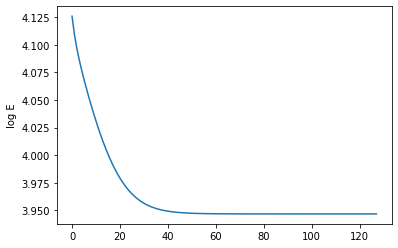

In [ ]:
flist_standard, pk, gk,k  = gradient_descent(f,g,np.zeros(len(m_y)),n_x.sum())
print('price vector    =' , pk)
print('number of steps =', k)
print('gradient        =' , gk)
plt.plot(np.log(np.array(flist_standard)))
plt.ylabel('log E')
plt.show()

Alternatively, we shall optimize using scipy `optimize` toolbox. Here, we use method = `CG` which is conjugate gradient -- to be discussed soon.

In [ ]:
from scipy import optimize

In [ ]:
outcome = optimize.minimize(f,jac = g, method = 'CG', x0=np.zeros(len(m_y)),options={'gtol':1e-3,'disp': True}) 
pstar = outcome['x']
print(pstar)
print(g(pstar))

Optimization terminated successfully.
         Current function value: 51.762796
         Iterations: 6
         Function evaluations: 13
         Gradient evaluations: 13
[2.39758 2.45947 3.1099 ]
[-0.00001  0.00003  0.     ]


# Lecture 21: acceleration and Newton's method

## Acceleration

In [ ]:
def accelerated_gradient_descent(f,g, p0, beta, grad_tol = 1e-3, maxIt = 1000):
  keep_going = True
  k = 1
  ptildek =  p0 -  g(p0) / beta
  pk = ptildek.copy()
  lambdak = 1
  flist = [f(ptildek)]
  while keep_going:
    k += 1
    newlambdak = (1+ sqrt(1+ 4* lambdak* lambdak) ) / 2
    thetak = (lambdak - 1 ) / newlambdak
    lambdak =  newlambdak
    newptildek = pk -  g(pk) / beta
    pk = (1+thetak)*newptildek - thetak * ptildek
    ptildek = newptildek
    flist.append(f(ptildek))
    if k>maxIt:
      keep_going = False
    if np.linalg.norm(g(ptildek)) < grad_tol:
      keep_going = False
  fvalues= np.array(flist)
  return flist, pk, g(pk),k 

price vector    = [2.39576 2.45812 3.10838]
number of steps = 74
gradient        = [-0.00239 -0.00172 -0.00198]


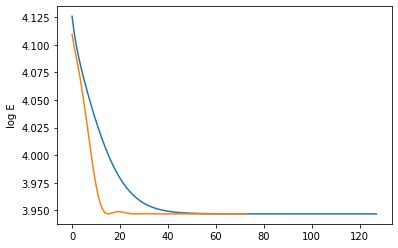

In [ ]:
flist_acc, pk, gk,k  = accelerated_gradient_descent(f,g,np.zeros(len(m_y)),n_x.sum())
print('price vector    =' , pk)
print('number of steps =', k)
print('gradient        =' , gk)
plt.plot(np.log(np.array(flist_standard)))
plt.plot(np.log(np.array(flist_acc)))
plt.ylabel('log E')
plt.show()

## Newton's method

In [ ]:
def newton_descent(f,g, F, p0, alpha = 1, grad_tol = 1e-3, maxIt = 1000):
  keep_going = True
  pk = p0
  k = 0
  flist = [f(pk)]
  while keep_going:
    gk = g(pk)
    pk = pk -  alpha * np.linalg.solve(F(pk) ,gk)  
    k = k+1
    fk = f(pk)
    flist.append(fk)
    if k>maxIt:
      print('Max iteration reached.')
      keep_going = False
    if np.linalg.norm(gk) < grad_tol:
      keep_going = False
  fvalues= np.array(flist)
  return flist, pk, g(pk),k 

In [ ]:
def F(p_y):
    denom_x = 1+ np.exp( U_x_y - p_y[None,:] ).sum(axis = 1)
    nby = len(p_y)
    nbx = len(denom_x)
    Hess_y_y = np.zeros((nby,nby))
    for x in range(nbx):
      pi_y =  (np.exp( U_x_y[x,:] - p_y ) /  denom_x[x]).flatten()
      Hess_y_y +=  n_x[x] * ( np.diag(pi_y) - pi_y.reshape((nby,1)) * pi_y.reshape((1,nby)) )
    return Hess_y_y

price vector    = [2.3977  2.45961 3.11007]
number of steps = 14
gradient        = [0.00006 0.00025 0.00029]


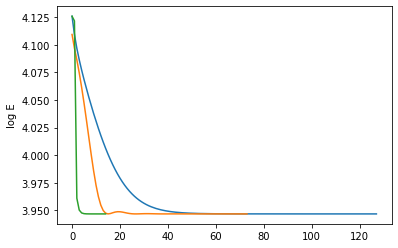

In [ ]:
flist_Newton, pk, gk,k  = newton_descent(f,g,F ,np.zeros(len(m_y)),alpha = 0.5)
print('price vector    =' , pk)
print('number of steps =', k)
print('gradient        =' , gk)
plt.plot(np.log(np.array(flist_standard)))
plt.plot(np.log(np.array(flist_acc)))
plt.plot(np.log(np.array(flist_Newton)))
plt.ylabel('log E')
plt.show()


# Lecture 22: stochastic gradient descent

In [ ]:
titanic_df = pd.read_csv('https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv', sep=',')
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [ ]:
y_i = np.array(titanic_df['Survived']) 
nbi = len(y_i)
x_i_k = np.array( [[1]*nbi, titanic_df['Pclass'],titanic_df['Sex'] == 'female', titanic_df['Siblings/Spouses Aboard']/8,titanic_df['Fare']/1000],dtype=float).T
_,nbk = x_i_k.shape

In [ ]:
def li(theta_k,i):
  return - y_i[i] * x_i_k[i,:].dot(theta_k) + np.log(1+np.exp( x_i_k[i,:].dot(theta_k)))

def gradli(theta_k,i):
  return ( 1 / (1+np.exp( - x_i_k[i,:].dot(theta_k))) - y_i[i] ) * x_i_k[i,:]

def L(theta_k):
  return (- y_i @ x_i_k @ theta_k + np.log(1+np.exp( x_i_k @ theta_k)).sum()) / nbi

def gradL(theta_k):
  return ( 1 / (1+np.exp( - x_i_k @ theta_k)) - y_i ) @ x_i_k / nbi

parameter vector= [ 0.4992  -0.87865  2.39089  0.57898  1.01686]
number of steps = 423
gradient        = [-0.00063  0.00143 -0.00742  0.00644 -0.00016]


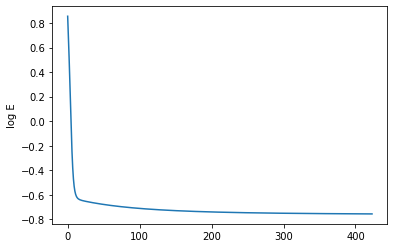

In [ ]:
flist_titanic, theta_k, gk,nbsteps  = gradient_descent(L,gradL,1*np.ones(nbk),(x_i_k*x_i_k).sum()/nbi,grad_tol=1e-2, maxIt = 1e4)
print('parameter vector=' , theta_k)
print('number of steps =', nbsteps)
print('gradient        =' , gk)
plt.plot(np.log(np.array(flist_titanic)))
plt.ylabel('log E')
plt.show()

In [ ]:
def stochastic_gradient_descent(f,g, p0, beta, alpha = None, batch_size = 1,  nbIt = 1000):
  keep_going = True
  pk = p0
  k = 0
  flist = [f(pk)]
  if alpha is None:
    alpha = lambda k: 1/beta
  for epoch in range(nbIt):
    batch = np.random.permutation(nbi)[0:batch_size]
    gk = 0.0
    for i in batch:
      gk += gradli(pk,i)
    gk = gk / batch_size
    pk = pk -  gk * alpha(k)
    k = k+1
    fk = f(pk)
    flist.append(fk)
  fvalues= np.array(flist)
  return flist, pk, g(pk)

parameter vector= [ 0.68665 -0.67257  2.95925  0.64426  1.01989]
gradient        = [0.13156 0.33036 0.05461 0.01645 0.00322]


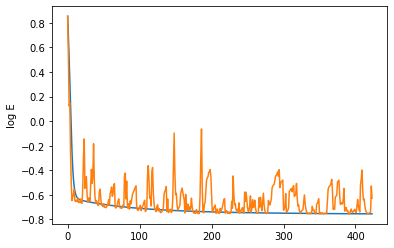

In [ ]:
np.random.seed(1)
flist_titanic_sgd, theta_k, gk  = stochastic_gradient_descent(L,gradL,1*np.ones(nbk), (x_i_k*x_i_k).sum()/nbi,batch_size =1, nbIt = nbsteps)
print('parameter vector=' , theta_k)
print('gradient        =' , gk)
plt.plot(np.log(np.array(flist_titanic)))
plt.plot(np.log(np.array(flist_titanic_sgd)))
plt.ylabel('log E')
plt.show()

The following takes batches of size 5:

parameter vector= [ 0.45595 -0.73611  2.56171  0.6082   1.03488]
gradient        = [0.05403 0.14245 0.02116 0.01084 0.00111]


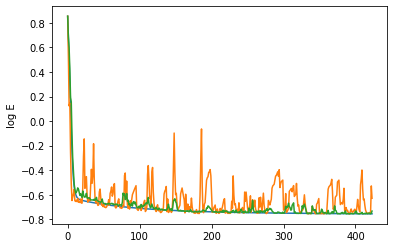

In [ ]:
np.random.seed(1)
flist_titanic_sgd_size5, theta_k, gk  = stochastic_gradient_descent(L,gradL,1*np.ones(nbk), (x_i_k*x_i_k).sum()/nbi,batch_size =5, nbIt = nbsteps)
print('parameter vector=' , theta_k)
print('gradient        =' , gk)
plt.plot(np.log(np.array(flist_titanic)))
plt.plot(np.log(np.array(flist_titanic_sgd)))
plt.plot(np.log(np.array(flist_titanic_sgd_size5)))
plt.ylabel('log E')
plt.show()

The following implements a diminishing step: $$\alpha_k =\frac {1} {k}.$$ 

parameter vector= [ 0.61029 -0.81982  1.59605  0.9717   1.04253]
gradient        = [-0.01037 -0.02188 -0.04288  0.00633 -0.00059]


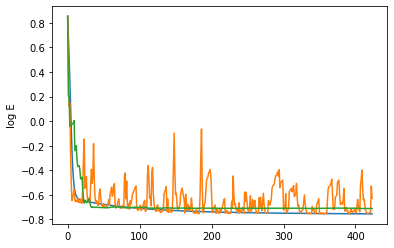

In [ ]:
np.random.seed(1)
flist_titanic_sgd_decreasing_step, theta_k, gk  = stochastic_gradient_descent(L,gradL,1*np.ones(nbk), (x_i_k*x_i_k).sum()/nbi, alpha = lambda k:1/(k+1),batch_size =1, nbIt = nbsteps)
print('parameter vector=' , theta_k)
print('gradient        =' , gk)
plt.plot(np.log(np.array(flist_titanic)))
plt.plot(np.log(np.array(flist_titanic_sgd)))
plt.plot(np.log(np.array(flist_titanic_sgd_decreasing_step)))
plt.ylabel('log E')
plt.show()

# Quasi-Newton methods

In [ ]:
def more_descent(f,g, x0,  method, nbIt = 1000, gtol = 1e-3, disp=True, maxiter = 1000):
    global the_flist
    the_flist=[]
    
    def printx(Xi):
        global the_flist
        the_flist.append(  f(Xi) )

    outcome = optimize.minimize(f,jac = g, method = method, x0=x0,callback=printx, options={'gtol':gtol,'disp': disp, 
                                                                                                           'maxiter':maxiter}) 
    pstar = outcome['x']
    return the_flist.copy(), pstar, g(pstar),outcome['nit']

Optimization terminated successfully.
         Current function value: 51.762796
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
price vector    = [2.39786 2.45961 3.11013]
number of steps = 7
gradient        = [0.0004  0.00013 0.00032]


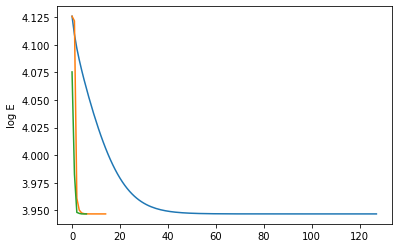

In [ ]:
flist_BFGS, pk, gk,k  = more_descent(f,g,np.zeros(len(m_y)),'BFGS')
print('price vector    =' , pk)
print('number of steps =', k)
print('gradient        =' , gk)
plt.plot(np.log(np.array(flist_standard)))
plt.plot(np.log(np.array(flist_Newton)))
plt.plot(np.log(np.array(flist_BFGS)))
plt.ylabel('log E')
plt.show()

# Lecture 24: Conjugate gradient descent

In [ ]:
np.random.seed(77)
d = 10
a = 3
A = 7
# kappa = A / a
draws = np.random.uniform(size = d)
eigenvalues =  a+(A-a)* ((draws - draws.min()) / (draws.max() - draws.min()) )
U = ortho_group.rvs(d) # generates a random orthogonal matrix
Q = U.T @ np.diag(eigenvalues ) @ U
b = np.ones(d)

In [ ]:
xk = np.zeros(d)
gk = b - Q @ xk
dk = b - Q @ xk
for k in range(d):
  alphak = - dk.dot(gk) / dk.dot(Q @ dk)
  xk = xk + alphak * dk
  gk = Q @ xk - b
  betak = dk.dot(Q@gk) / dk.dot(Q @ dk)
  dk = -gk + betak* dk 

xstar = np.linalg.solve(Q ,b)  
print((np.abs(xk -xstar) ).max())


2.4832233547211757e-08


# Lecture 26: proximal gradient descent

We first construct the soft thresholding operator:

In [ ]:
def S(y_i,eta):
  nbi = len(y_i)
  x_i = np.zeros(nbi)
  for i in range(nbi):
    if y_i[i] > eta:
      x_i[i] = y_i[i] - eta
    elif y_i[i] < - eta:
      x_i[i] = y_i[i] + eta
  return x_i

Next, we implement proximal gradient descent:

In [ ]:
def proximal_gradient_descent(f,g, x0,gamma,  alpha, grad_tol = 1e-3, maxIt = 1000):
  keep_going = True
  xk = x0
  k = 0
  flist = [f(xk)]
  while keep_going:
    gk = g(xk)
    yk = xk -  alpha * gk 
    newxk = S(yk,alpha*gamma)
    k = k+1
    fk = f(xk)
    flist.append(fk)
    if k>maxIt:
      print('Max iteration reached.')
      keep_going = False
    if np.linalg.norm( (newxk - xk) / alpha ) < grad_tol:
      keep_going = False
    xk = newxk
  fvalues= np.array(flist)
  return flist, xk, g(xk),k 

We compute the logistic regression with L1 penalization:

gd, parameter vector = [ 0.4992  -0.87865  2.39089  0.57898  1.01686]
gd, number of steps  = 423
pgd, parameter vector= [ 0.46248 -0.85957  2.38362  0.51179  0.96217]
pgd, number of steps = 439


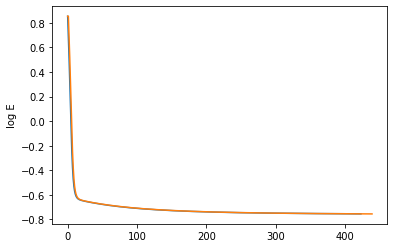

In [ ]:
gamma = 1e-3 # try 1e-3, 1e-2, 1e-1, 1.0
flist_titanic, theta_k, gk,nbsteps  = gradient_descent(L,gradL,1*np.ones(nbk),(x_i_k*x_i_k).sum()/nbi,grad_tol=1e-2, maxIt = 1e4)
print('gd, parameter vector =' , theta_k)
print('gd, number of steps  =', nbsteps)
#print('gd, gradient         =' , gk)
flist_titanic_pgd, theta_k, gk,nbsteps  = proximal_gradient_descent(L,gradL,1*np.ones(nbk), gamma,nbi/(x_i_k*x_i_k).sum(),grad_tol=1e-2,)
print('pgd, parameter vector=' , theta_k)
print('pgd, number of steps =', nbsteps)
#print('pgd, gradient        =' , gk)
plt.plot(np.log(np.array(flist_titanic)))
plt.plot(np.log(np.array(flist_titanic_pgd)))
plt.ylabel('log E')
plt.show()